In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import sys

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag, wordnet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud

#nltk.download('vader_lexicon')

#Settings
pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(threshold=sys.maxsize)
sns.set()
DIMS=(20, 10)

In [2]:
# print("Downloading corpora...")    
# nltk.download('punkt')                        # Sentence Tokenizer
# nltk.download('stopwords')                    # For stopwords in all languages
# nltk.download('averaged_perceptron_tagger')   # For Sentiment analysis
# nltk.download('wordnet')                      # For Lemmas
# print("Downloads complete.")

In [3]:
reviews_df = pd.read_csv('Womens-Clothing-E-Commerce-Reviews.csv',index_col=0)
reviews_df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### Exploratory analysis

Check for null values

In [4]:
reviews_df.isnull().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [5]:
845/23485

0.03598041302959336

Since null values in `Review Text` column only takes up a negligible 0.04% of the dataset, we'll exclude these records.

In [6]:
reviews_df_drop = reviews_df.copy()
reviews_df_drop.dropna(axis=0, inplace=True)

In [7]:
reviews_df_drop.isnull().sum()

Clothing ID                0
Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
dtype: int64

In [8]:
reviews_df_drop.describe()

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,19662.00,19662.00,19662.00,19662.00,19662.00
mean,921.30,43.26,4.18,0.82,2.65
std,200.23,12.26,1.11,0.39,5.83
min,1.00,18.00,1.00,0.00,0.00
25%,861.00,34.00,4.00,1.00,0.00
50%,936.00,41.00,5.00,1.00,1.00
75%,1078.00,52.00,5.00,1.00,3.00
max,1205.00,99.00,5.00,1.00,122.00


In [9]:
reviews_df.dtypes

Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
dtype: object

In [10]:
reviews_df_drop['Clothing ID'].nunique()

1095

In [11]:
reviews_df.shape

(23486, 10)

The number of unique values in `Clothing ID` is significantly lesser than the number of rows. This shows the Clothing ID are not unique. This is understandable, given that Clothing ID is the product that is being reviewed. Hence, this shows the same product was purchased and reviewed by multiple customers

However, this also means that we can find out what are the popular items (i.e those that appear more than 'n' times) that customers have commonly purchased and reviewed. In this case, I set an arbitray 'n' to be 100.

In [12]:
vc = reviews_df_drop['Clothing ID'].value_counts() > 100
vc = vc[vc]

popular_items_df = reviews_df_drop.loc[reviews_df_drop['Clothing ID'].isin(vc.index)]   
popular_items_df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
8,1077,24,Flattering,I love this dress. i usually get an xs but it ...,5,1,0,General,Dresses,Dresses
9,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,General,Dresses,Dresses
10,1077,53,Dress looks like it's made of cheap material,Dress runs small esp where the zipper area run...,3,0,14,General,Dresses,Dresses


In [13]:
popular_items = []
for i in popular_items_df['Clothing ID']:
    if i not in popular_items:
        popular_items.append(i)
    
print('These are the list of popular items:' , str(popular_items))

These are the list of popular items: [1077, 1080, 1095, 862, 1078, 850, 1082, 836, 1081, 1072, 861, 863, 1008, 829, 828, 1020, 895, 1104, 868, 1094, 872, 984, 831, 936, 907, 1086, 1035, 1083, 833, 820, 875, 835, 1059, 1087, 1110, 873, 1033, 1022, 854, 909, 864, 1099, 877, 860, 940, 865, 867, 927, 1092, 834, 1056]


Given the age group of reviewers spans over wide range of age, we'll categorise them into separate bins (10-20], (20-30] etc. This enables subsequent analysis to be more meaningful, because based on the ratings and sentiments of each age group, the company can tailor its marketing strategies accordingly or provide a more unique shopping experience for each age group, assuming that women in the same age group tend to share some similarities.

In [14]:
bins = np.arange(0,100,10)
reviews_df_drop['Age group'] = pd.cut(reviews_df['Age'], bins)
reviews_df_drop.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Age group
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,"(50, 60]"
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"(40, 50]"
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,"(40, 50]"
5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses,"(40, 50]"
6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits,"(30, 40]"


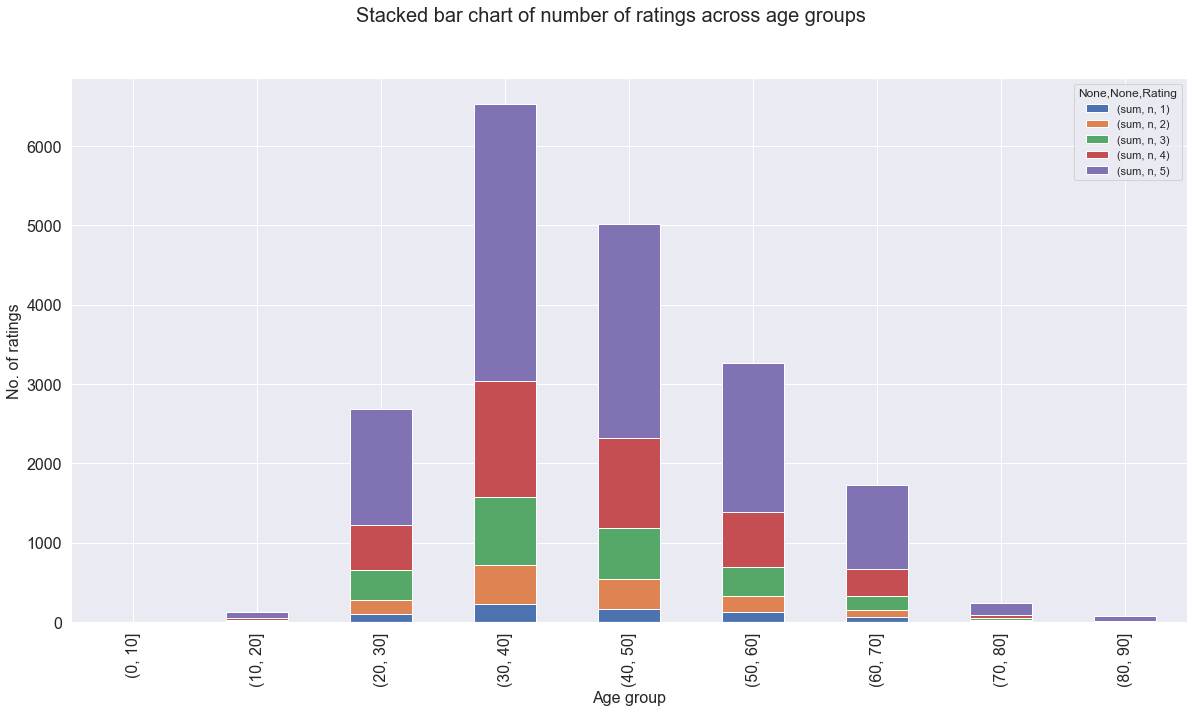

In [15]:
fig = plt.figure(figsize=DIMS)
ax = fig.add_subplot(111)


ratings_count_df = reviews_df_drop.groupby(['Rating', reviews_df_drop['Age group']]).size().reset_index(name='n')
ratings_count_df.columns

ratings_count_df_pivot = pd.pivot_table(ratings_count_df,index=["Age group"],
               values=["n"],
               columns=["Rating"],
               aggfunc=[np.sum])

ratings_count_df_pivot
ratings_count_df_pivot.plot(kind = 'bar', stacked=True, fontsize = 16, ax=ax)
ax.set_ylabel("No. of ratings", fontsize=16)
ax.set_xlabel("Age group", fontsize=16)
fig.suptitle('Stacked bar chart of number of ratings across age groups', fontsize=20)
plt.show()

Conclusion: Women in the 30s to 40s give the most number of online reviews, followed by women in the 30s to 40s, 50s to 60s then young women in their 20s to 30s . This is surprising, given that e-commerce sites tend to be more popular among young women. Perhaps youngsters shop online but do not provide their ratings, thus these people are not captured in dataset.

The most common rating given is 5 across women from ages 20 to 70. While this could mean the e-commerce company may be doing a good job at providing a good shopping experience for their customers, analysing the sentiments of the customers' reviews will tell us a more holistic story. 

##### Text normalisation on `Review Text`

In [16]:
def clean_string(r):
    #remove regular expression and change to lowercase
    r1 = re.sub('[A-Z][a-z]+', ' ', str(r))
    r1 = r1.strip().lower()
   
    #remove stopwords
    no_sw = []
    if r1 not in stopwords.words():
        no_sw.append(r1)
        
   #perform stemming
    stemmer = PorterStemmer() 
    final_list = []

    for i in no_sw:
        final_list.append(stemmer.stem(str(i)))
                
    return final_list

In [40]:
only_reviews_df = reviews_df_drop.copy()
only_reviews_df= only_reviews_df[['Clothing ID','Review Text', 'Age group', 'Recommended IND']]
only_reviews_df['Filtered Reviews'] = only_reviews_df['Review Text'].apply(clean_string)
only_reviews_df.head()

,Clothing ID,Review Text,Age group,Recommended IND,Filtered Reviews
2,1077,I had such high hopes for this dress and reall...,"(50, 60]",0,[i had such high hopes for this dress and real...
3,1049,"I love, love, love this jumpsuit. it's fun, fl...","(40, 50]",1,"[i love, love, love this jumpsuit. it's fun, f..."
4,847,This shirt is very flattering to all due to th...,"(40, 50]",1,[shirt is very flattering to all due to the ad...
5,1080,"I love tracy reese dresses, but this one is no...","(40, 50]",0,"[i love tracy reese dresses, but this one is n..."
6,858,I aded this in my basket at hte last mintue to...,"(30, 40]",1,[i aded this in my basket at hte last mintue t...


##### Sentiment analysis on `Filtered reviews`

In [18]:
sid = SentimentIntensityAnalyzer()

num_records = only_reviews_df.shape[0]
ones_array = np.ones(num_records)
    
only_reviews_df['Compound score'] = ones_array

for i in range(len(only_reviews_df['Filtered Reviews'])):

    element = only_reviews_df['Filtered Reviews'].iloc[i][0]
#     print(element)
    score = sid.polarity_scores(element)
    compound = score['compound']
#     print(compound)
    only_reviews_df['Compound score'].iloc[i] = compound
only_reviews_df.head()


E:\python\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Clothing ID,Review Text,Age group,Recommended IND,Filtered Reviews,Compound score
2,1077,I had such high hopes for this dress and reall...,"(50, 60]",0,[i had such high hopes for this dress and real...,0.94
3,1049,"I love, love, love this jumpsuit. it's fun, fl...","(40, 50]",1,"[i love, love, love this jumpsuit. it's fun, f...",0.57
4,847,This shirt is very flattering to all due to th...,"(40, 50]",1,[shirt is very flattering to all due to the ad...,0.93
5,1080,"I love tracy reese dresses, but this one is no...","(40, 50]",0,"[i love tracy reese dresses, but this one is n...",0.94
6,858,I aded this in my basket at hte last mintue to...,"(30, 40]",1,[i aded this in my basket at hte last mintue t...,0.80


##### Classify sentiments into different bins of age groups

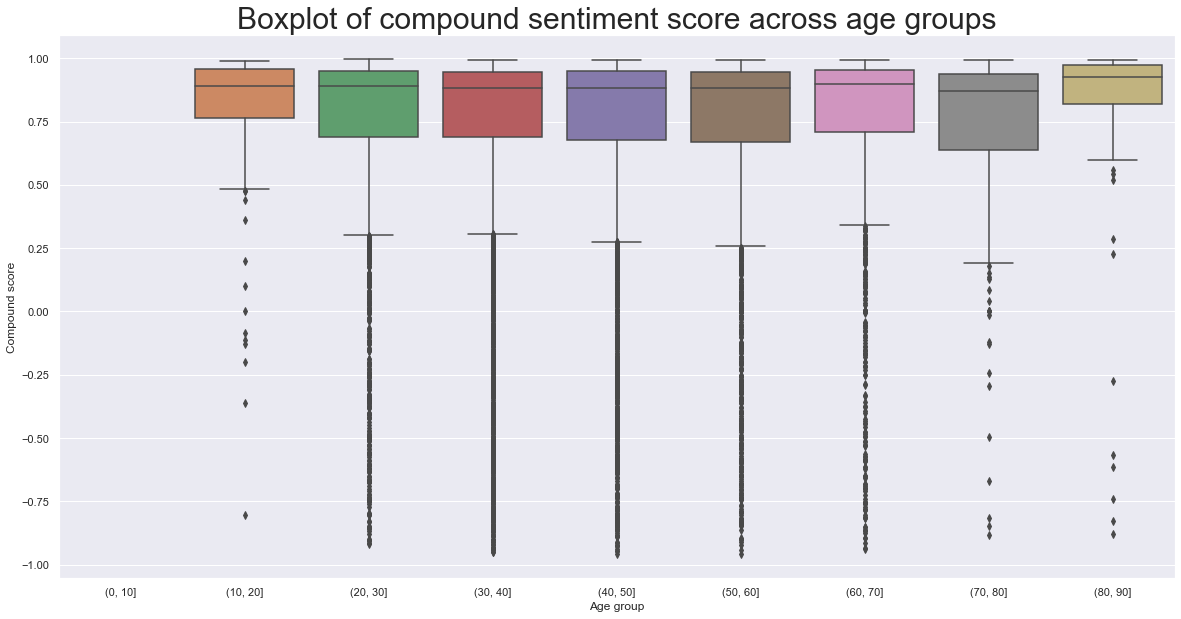

In [19]:

fig = plt.figure(figsize=DIMS)
ax = fig.add_subplot(111)

sns.boxplot(data=only_reviews_df[['Compound score', 'Age group']],x= 'Age group',y='Compound score', ax=ax, )
ax.set_title('Boxplot of compound sentiment score across age groups', fontsize=30)

plt.show()

Conclusion: Women across all age groups have given very positive sentiments about their shopping experience, with a general compound polarity of 0.9. However, there are more outliers in sentiment scores amongst women from 20s to 70s. 

##### Classify sentiments into positive, negative, neutral

In [20]:
category = []

for i in only_reviews_df['Compound score']: 
    
    if i > 0:
        category.append('Positive')

    elif i < 0:
        category.append('Negative')

    else:
        category.append('Neutral')

only_reviews_df['Sentiment category'] = category
only_reviews_df.tail()

,Clothing ID,Review Text,Age group,Recommended IND,Filtered Reviews,Compound score,Sentiment category
23481,1104,I was very happy to snag this dress at such a ...,"(30, 40]",1,[i was very happy to snag this dress at such a...,0.92,Positive
23482,862,"It reminds me of maternity clothes. soft, stre...","(40, 50]",1,"[reminds me of maternity clothes. soft, stretc...",0.67,Positive
23483,1104,"This fit well, but the top was very see throug...","(30, 40]",0,"[fit well, but the top was very see through. t...",0.93,Positive
23484,1084,I bought this dress for a wedding i have this ...,"(20, 30]",1,[i bought this dress for a wedding i have this...,0.67,Positive
23485,1104,This dress in a lovely platinum is feminine an...,"(50, 60]",1,[dress in a lovely platinum is feminine and fi...,0.94,Positive


##### Number of sentiment categories

In [21]:
num_sentiment_df = only_reviews_df.copy()
num_sentiment_df = num_sentiment_df[['Clothing ID', 'Sentiment category']]
num_sentiment_agg = num_sentiment_df.groupby('Sentiment category').size().reset_index(name='No. of sentiments')
num_sentiment_agg

,Sentiment category,No. of sentiments
0,Negative,1320
1,Neutral,190
2,Positive,18152


In [22]:
num_sentiment_agg.columns

Index(['Sentiment category', 'No. of sentiments'], dtype='object')

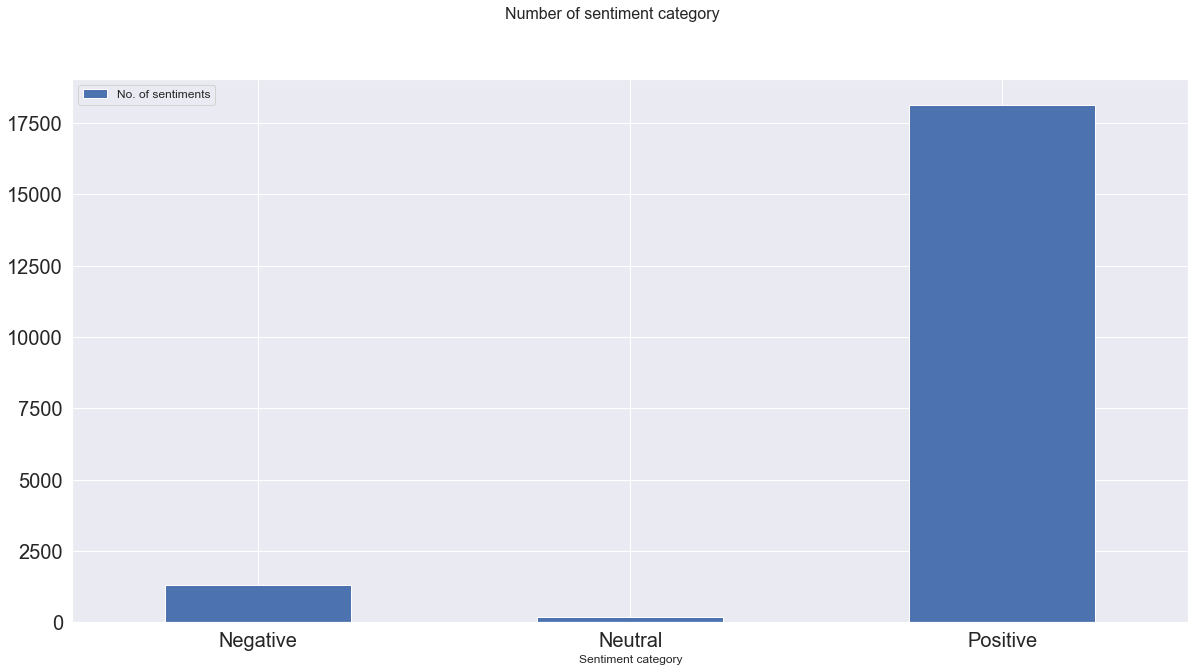

In [23]:
fig, ax = plt.subplots()
num_sentiment_agg.plot(kind='bar', x='Sentiment category', y='No. of sentiments', figsize = DIMS, ax=ax, rot=0, fontsize = 20)
fig.suptitle('Number of sentiment category', fontsize=16)
ax.legend(['No. of sentiments'], fontsize=12)

Given that there are a lot more positive reviews, the list of popular items found earlier should reflect positive sentiments about their purchase. The company can consider manufacturing or bringing in more of such type of apparels. 

The large proportion of positive reviews also corresponds with the greater proportion of maximum (5/5) ratings given.  

Wordcloud for each category of sentiments

In [24]:
positive_reviews = only_reviews_df.loc[only_reviews_df['Sentiment category']=='Positive', 'Filtered Reviews']

pos_rev_desc = ''
for i in positive_reviews:
    for x in i:
        pos_rev_desc = pos_rev_desc + '' + x  

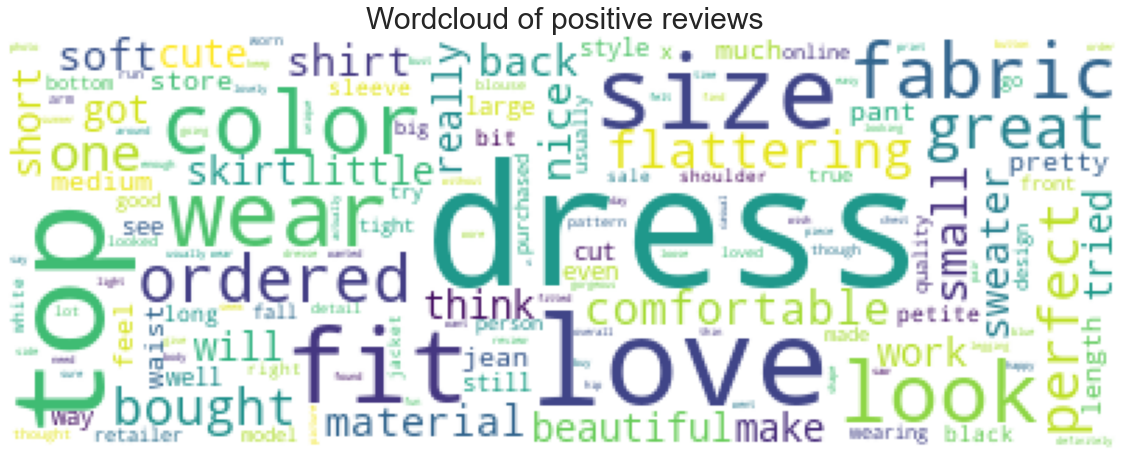

In [25]:

# positive_reviews = only_reviews_df.loc[only_reviews_df['Sentiment category']=='Positive', 'Filtered Reviews'].tolist()


fig = plt.figure(figsize=DIMS)
desc_wordcloud = WordCloud(
    width=400, height=150,
    background_color="white", 
    max_words=150, relative_scaling = 1.0).generate(pos_rev_desc)
plt.imshow(desc_wordcloud)
plt.axis("off")
plt.title("Wordcloud of positive reviews", fontsize=30)
plt.show()

In [26]:
negative_reviews = only_reviews_df.loc[only_reviews_df['Sentiment category']=='Negative', 'Filtered Reviews']

neg_rev_desc = ''
for i in negative_reviews:
    for x in i:
        neg_rev_desc = neg_rev_desc + '' + x  


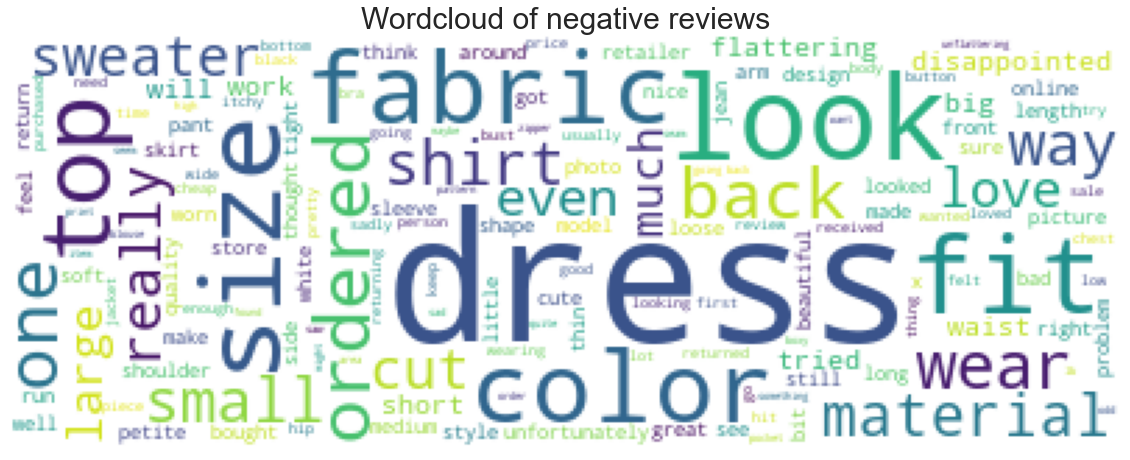

In [27]:
fig = plt.figure(figsize=DIMS)
desc_wordcloud = WordCloud(
    width=400, height=150,
    background_color="white", 
    max_words=150, relative_scaling = 1.0).generate(neg_rev_desc)
plt.imshow(desc_wordcloud)
plt.axis("off")
plt.title("Wordcloud of negative reviews", fontsize=30)
plt.show()

Conclusion: 

The main elements contributing to both positive and negative reviews are top, dress. However, words like fit and size are more commonly associated with negative reviews, while words such as fabric and colour appear more often with positive reviews. While it seems that generally, the experience from the purchase of tops and dresses from this e-commerce company generate mixed reviews, I feel that the company can continue with its current choice of fabric and colour it chose for its tops and dresses, given that the proportion of positive reviews are significantly larger than negative reviews. 

In [28]:
neutral_reviews = only_reviews_df.loc[only_reviews_df['Sentiment category']=='Neutral', 'Filtered Reviews']

neut_rev_desc = ''
for i in neutral_reviews:
    for x in i:
        neut_rev_desc = neut_rev_desc + '' + x

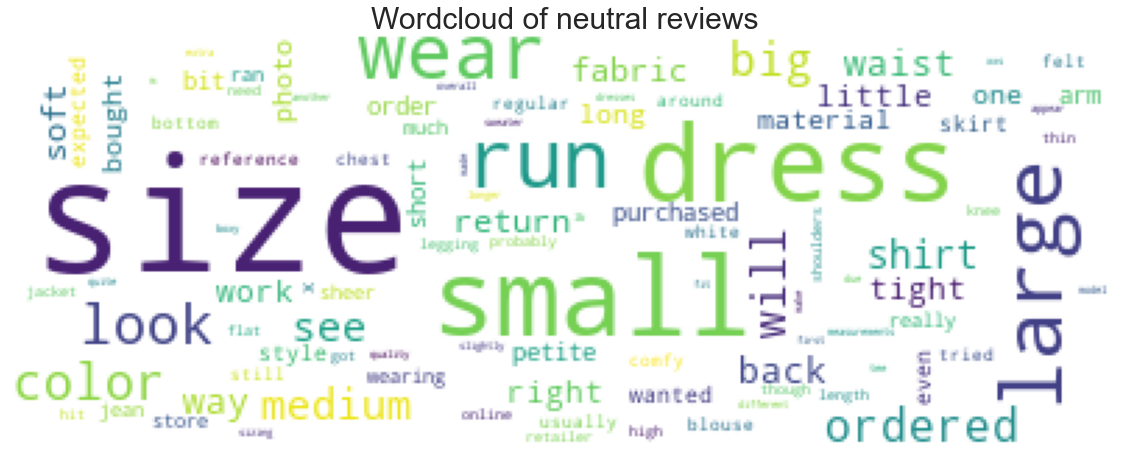

In [29]:
fig = plt.figure(figsize=DIMS)
desc_wordcloud = WordCloud(
    width=400, height=150,
    background_color="white", 
    max_words=150, relative_scaling = 1.0).generate(neut_rev_desc)
plt.imshow(desc_wordcloud)
plt.axis("off")
plt.title("Wordcloud of neutral reviews", fontsize=30)
plt.show()

#### Apply the Naïve Bayes Classification Algorithm on Sentiment category to predict if item is recommended

##### Train 

In [30]:
X = only_reviews_df['Sentiment category']
y = only_reviews_df['Recommended IND']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

Apply CountVectorizer and TdidfTransformer transformations

In [31]:
count_vect = CountVectorizer()
tfidf_tfm = TfidfTransformer()
train_df_counts = count_vect.fit_transform(X_train)
train_df_tfidf = tfidf_tfm.fit_transform(train_df_counts)

Fit the model using Naïve Bayes Classification.

In [32]:
clf = MultinomialNB().fit(train_df_tfidf, y_train)

##### Test

In [33]:
count_test_vect = count_vect.transform(X_test)
y_predict = clf.predict(count_test_vect)

###### Evaluate Model

Compare results in predicted model against the original results

In [34]:
y_confusion_df = pd.DataFrame({"y_test": y_test, "y_predict" : y_predict} )
y_confusion_df.head()

,y_test,y_predict
12840,0,0
7802,1,1
5146,0,0
17452,0,1
6946,0,0


In [35]:
cm = confusion_matrix(y_test, y_predict)
cm

array([[ 210,  729],
       [ 143, 3834]], dtype=int64)

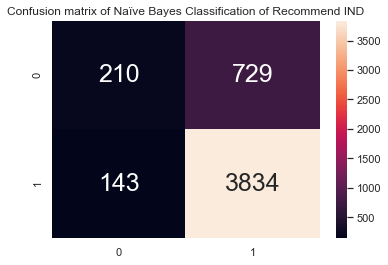

In [36]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
sns.heatmap(cm, annot=True, fmt='.0f', annot_kws={"size": 25}, ax=ax1)
ax1.set_title("Confusion matrix of Naïve Bayes Classification of Recommend IND")
plt.show()

In [37]:
print("True negatives:", (cm[0][0]))
print("True positives:", (cm[1][1]))
print("False negatives:", (cm[0][1]))
print("Total:", (sum(sum(cm))))
print("Accuracy:", ((cm[0][0] + cm[1][1])/sum(sum(cm))))
print("Proportion of False negatives:", (cm[0][1] /sum(sum(cm))))

True negatives: 210
True positives: 3834
False negatives: 729
Total: 4916
Accuracy: 0.822620016273393
Proportion of False negatives: 0.1482912937347437


Conclusion: Accuracy of model is 83.8%

More importantly, 14.2% of the time, the model wrongly predicts that a customer would recommend her product based on her sentiments, when she actually would not have 

##### Inspect the wrongly classified reviews.

In [38]:
only_reviews_df['id'] = only_reviews_df.index
y_confusion_df['id'] = y_confusion_df.index

wrong_indices = y_confusion_df[
    y_confusion_df['y_test'] != y_confusion_df['y_predict']].index

mismatch_df = only_reviews_df.merge(y_confusion_df, on='id')
mismatch_df = mismatch_df[mismatch_df['id'].isin(wrong_indices)]
mismatch_df.head()

,Clothing ID,Review Text,Age group,Recommended IND,Filtered Reviews,Compound score,Sentiment category,id,y_test,y_predict
0,1077,I had such high hopes for this dress and reall...,"(50, 60]",0,[i had such high hopes for this dress and real...,0.94,Positive,2,0,1
3,858,"I ordered this in carbon for store pick up, an...","(30, 40]",1,"[i ordered this in carbon for store pick up, a...",-0.09,Negative,7,1,0
4,1077,"I'm 5""5' and 125 lbs. i ordered the s petite t...","(30, 40]",1,"[i'm 5""5' and 125 lbs. i ordered the s petite ...",-0.37,Negative,9,1,0
9,697,"Loved the material, but i didnt really look at...","(30, 40]",0,"[the material, but i didnt really look at how ...",0.88,Positive,25,0,1
14,862,I really loved this top online and wanted to l...,"(30, 40]",0,[i really loved this top online and wanted to ...,0.91,Positive,68,0,1


In [39]:
spl = mismatch_df.sample()
print(spl[['Clothing ID', 'id','y_test','y_predict']])
print()
print(spl.iloc[0]['Filtered Reviews'])

      Clothing ID     id  y_test  y_predict
3364         1038  16119       0          1

['i looked like i was going to work on a farm. well made, but seemed fit big. i like and have owned wide leg pants/capris, these were cartoonishly wide.\n\nneedless to say, they were returned.']


The above sample shows how the model wrongly predicts that a customer would recommend her product based on her sentiments, when she actually would not have. Hence the model should be interpreted and used with caution.